# Improving the haemodynamic model with convolution

Start with our usual imports:

In [1]:
import numpy as np
# Only show 6 decimals when printing
np.set_printoptions(precision=6)

import matplotlib.pyplot as plt
%matplotlib inline

import nibabel as nib

Load the 4D image ready for analysis:

In [2]:
img = nib.load('ds114_sub009_t2r1.nii')
data = img.get_fdata()
data.shape

(64, 64, 30, 173)

## Getting the convolved regressor

## Using scipy

*Scipy* is a large library of scientific routines that builds on top of numpy.

You can think of Numpy as being a subset of MATLAB, and Numpy + Scipy as being
as being roughly equivalent to MATLAB plus the MATLAB toolboxes.

Scipy has many sub-packages, for doing things like reading MATLAB `.mat`
files (`scipy.io`) or working with sparse matrices (`scipy.sparse`). We
are going to be using the functions and objects for working with statistical
distributions in `scipy.stats`:

In [3]:
import scipy.stats

`scipy.stats` contains objects for working with many different distributions.
We are going to be working with `scipy.stats.gamma`, which implements the
[gamma distribution](https://en.wikipedia.org/wiki/Gamma_distribution).

In [4]:
from scipy.stats import gamma

In particular we are interested in the [probability density
function](https://en.wikipedia.org/wiki/Probability_density_function) (PDF) of
the gamma distribution.

Because this is a function, we need to pass it an array of values at which it
will evaluate.

We can also pass various parameters which change the shape, location and width
of the gamma PDF. The most important is the first parameter (after the input
array) known as the [shape
parameter](https://en.wikipedia.org/wiki/Shape_parameter) ($k$ in the
[wikipedia page on gamma
distributions](https://en.wikipedia.org/wiki/Gamma_distribution)).

First we chose some x values at which to sample from the gamma PDF:

In [5]:
# From 0 up to 25 in steps of 0.1
x = np.arange(0, 25, 0.1)

Next we plot the gamma PDF for shape values of 2, 4, 8, 12.

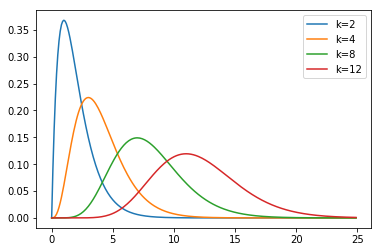

In [6]:
plt.plot(x, gamma.pdf(x, 2), label='k=2')
plt.plot(x, gamma.pdf(x, 4), label='k=4')
plt.plot(x, gamma.pdf(x, 8), label='k=8')
plt.plot(x, gamma.pdf(x, 12), label='k=12')
plt.legend();

## Constructing a haemodynamic response function

We can use these gamma functions to construct a continuous function that is
close to the haemodynamic response we observe for a single brief event in the
brain.

Our function will accept an array that gives the times we want to calculate the
HRF for, and returns the values of the HRF for those times.  We will assume
that the true HRF starts at zero, and gets to zero sometime before 35 seconds.

We’re going to try using the sum of two [gamma
distribution](https://en.wikipedia.org/wiki/Gamma_distribution) probability
density functions.

Here is one example of such a function:

In [7]:
def hrf(times):
    """ Return values for HRF at given times """
    # Gamma pdf for the peak
    peak_values = gamma.pdf(times, 6)
    # Gamma pdf for the undershoot
    undershoot_values = gamma.pdf(times, 12)
    # Combine them
    values = peak_values - 0.35 * undershoot_values
    # Scale max to 0.6
    return values / np.max(values) * 0.6

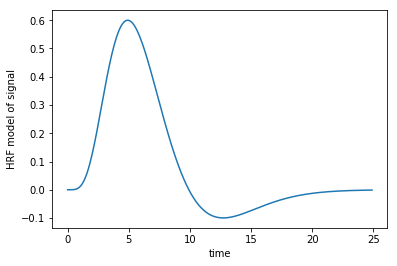

In [8]:
plt.plot(x, hrf(x))
plt.xlabel('time')
plt.ylabel('HRF model of signal');

We can sample from the function, to get the estimates at the times of our TRs.
Remember, the TR is 2.5 for our example data, meaning the scans were 2.5
seconds apart.

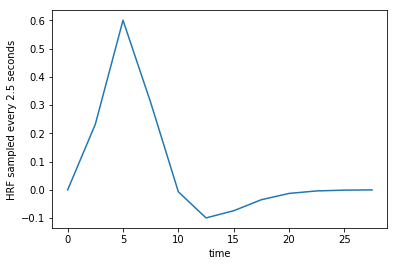

In [9]:
TR = 2.5
tr_times = np.arange(0, 30, TR)
hrf_at_trs = hrf(tr_times)
len(hrf_at_trs)
plt.plot(tr_times, hrf_at_trs)
plt.xlabel('time')
plt.ylabel('HRF sampled every 2.5 seconds');

## Making the convolved regressor

We can use this to convolve our neural (on-off) prediction.  This will give us
a haemodynamic prediction, under the linear-time-invariant assumptions of the
convolution.  You will recognize this snippet from the [voxel time
courses](../02/voxel_time_courses) notebook:

In [10]:
#- Make new zero vector for neural prediction
neural_prediction = np.zeros(img.shape[-1])
#- Read the file into an array called "task".
#- "task" should have 3 columns (onset, duration, amplitude)
task = np.loadtxt('ds114_sub009_t2r1_cond.txt')
#- Select first two columns and divide by TR
ons_durs = task[:, :2] / TR
#- Fill in values of 1 for positions of on blocks in time course
# Convert onsets, durations to integers first
ons_durs = np.round(ons_durs).astype(int)
for onset, duration in ons_durs:
    neural_prediction[onset:onset + duration] = 1

Plot the on-off neural predictor:

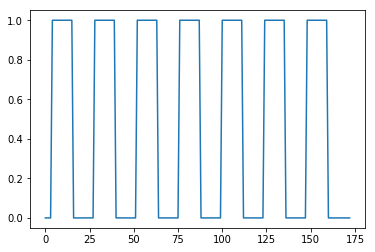

In [11]:
all_tr_times = np.arange(173)
plt.plot(all_tr_times, neural_prediction);

When we convolve, the output is length N + M-1, where N is the number of values
in the vector we convolved, and M is the length of the convolution kernel
(`hrf_at_trs` in our case).  For a reminder of why this is, see the [tutorial
on convolution](https://matthew-brett.github.io/teaching/on_convolution.html).

In [12]:
convolved = np.convolve(neural_prediction, hrf_at_trs)
N = len(neural_prediction)  # M == n_vols == 173
M = len(hrf_at_trs)  # M == 12
len(convolved) == N + M - 1

True

This is because of the HRF convolution kernel falling off the end of the input
vector. The value at index 172 in the new vector refers to time 172 \* 2.5
= 430.0 seconds, and value at index 173 refers to time 432.5 seconds, which is
just after the end of the scanning run. To retain only the values in the new
haemodynamic vector that refer to times up to (and including) 430s, we can just
drop the last `len(hrf_at_trs) - 1 == M - 1` values:

In [13]:
n_to_remove = len(hrf_at_trs) - 1
convolved = convolved[:-n_to_remove]

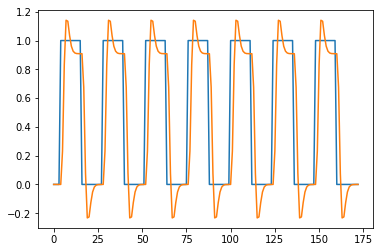

In [14]:
plt.plot(all_tr_times, neural_prediction)
plt.plot(all_tr_times, convolved);

## Using the convolved regressor

In [voxel time courses](../02/voxel_time_courses) you saw the correlation of
the neural predictor with the voxel time course.

Now we have a better predictor than the neural predictor.

The signal we have from the FMRI image is haemodynamic.  Therefore, the neural
signal gets transformed through the haemodynamic response function.

We should therefore correlate the voxel time course with a haemodynamic predictor - that is - the neural predictor convolved with the haemodynamic response function.

We get the voxel time course for the voxel we were looking at in [voxel time courses](../02/voxel_time_courses):

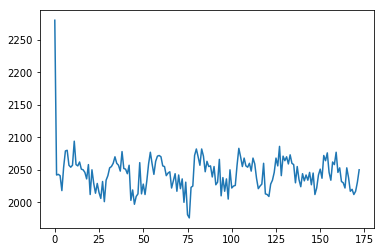

In [15]:
# This is slicing over all three of the space axes
voxel_time_course = data[42, 32, 19, :]
plt.plot(voxel_time_course);

First drop the first element of both regressors, to remove the T1 artifact:

In [16]:
# Drop the first volumes-worth from the regressor
convolved = convolved[1:]
voxel_time_course = voxel_time_course[1:]

Plot, and do correlation:

array([[1.      , 0.700467],
       [0.700467, 1.      ]])

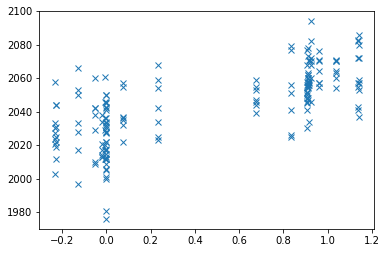

In [17]:
plt.plot(convolved, voxel_time_course, 'x')
np.corrcoef(convolved, voxel_time_course)

Compare to [voxel time courses](02/voxel_time_courses).